<a href="https://colab.research.google.com/github/vineeth-89/O-RADAR/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

T = 10000  # time steps
N_DU = 3
M_RU_per_DU = 5
delta_t = 0.01  # 10 ms resolution

def generate_kpi(t_idx, du_id, ru_id):
    λ_eMBB = np.random.poisson(20)
    λ_uRLLC = np.random.poisson(2.5)
    ue_count = np.random.poisson(λ_eMBB + λ_uRLLC)
    sinr = np.random.normal(15, 5)
    rsrp = np.random.normal(-90, 5)
    rsrq = np.random.uniform(-19, -3)
    se = np.log2(1 + max(sinr, 1e-5))  # spectral efficiency
    prb_util = min(100, np.random.beta(2, 5) * 100)
    prb_bandwidth = 180e3  # per PRB
    throughput = prb_util / 100 * se * prb_bandwidth * 12 / 1e6  # Mbps
    latency = 1 / max(1e-5, (10 - (λ_eMBB + λ_uRLLC)))  # simplified M/M/1
    handovers = np.random.poisson(0.5)
    ho_fails = np.random.binomial(handovers, 0.1)

    return {
        "timestamp": t_idx * delta_t,
        "DU_id": du_id,
        "RU_id": ru_id,
        "UE_count": ue_count,
        "PRB_utilization": prb_util,
        "throughput_mbps": throughput,
        "avg_latency_ms": latency * 1000,
        "rsrp_dBm": rsrp,
        "rsrq_dB": rsrq,
        "sinr_dB": sinr,
        "handover_attempts": handovers,
        "handover_failures": ho_fails,
        "eMBB_arrival_rate": λ_eMBB,
        "uRLLC_arrival_rate": λ_uRLLC,
    }

# Simulate
data = []
for t in range(T):
    for du in range(N_DU):
        for ru in range(M_RU_per_DU):
            data.append(generate_kpi(t, du, ru))

df = pd.DataFrame(data)
df.to_csv("synthetic_oran_kpi_dataset.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd

# Constants
T = 1,000,000                 # 100s at 10ms
dt = 0.01
RUs_per_DU = 5
W_rolling = 100            # 1s rolling avg
np.random.seed(42)

# Parameters for PRB estimation
target_mbps_per_ue = 1.0   # desired throughput per UE
total_PRBs = 100           # assume 100 PRBs for simplicity
prb_bw = 180e3             # PRB bandwidth in Hz
max_capacity_mbps = prb_bw * 12 * total_PRBs / 1e6  # 216 Mbps approx.

# Diurnal traffic pattern: morning & evening spikes
def diurnal_load(t):
    time_sec = t * dt
    return 0.6 + 0.4 * (np.sin(2 * np.pi * time_sec / 100) + 0.5 * np.sin(4 * np.pi * time_sec / 100))

# Simulate per-RU data
data = []
for t in range(T):
    load_factor = diurnal_load(t)
    timestamp = round(t * dt, 3)

    for ru_id in range(RUs_per_DU):
        # Total UE count sampled directly
        ue_count = np.random.poisson(load_factor * 10)

        # SINR affected by load and randomness
        interference = np.random.normal(0, 2)
        sinr = max(5, np.random.normal(15 - 0.02 * ue_count, 3) - interference)

        # RSRP, RSRQ
        rsrp = np.random.normal(-90, 4)
        rsrq = np.random.uniform(-19, -3)

        # Spectral Efficiency
        se = np.log2(1 + sinr)

        # PRB utilization (realistic, based on UE traffic demand)
        total_mbps_needed = ue_count * target_mbps_per_ue
        prb_util = (total_mbps_needed / (se * max_capacity_mbps)) * 100
        prb_util += np.random.normal(0, 5)  # small noise
        prb_util = np.clip(prb_util, 0, 100)

        # Throughput from PRB utilization
        throughput = prb_util / 100 * se * prb_bw * total_PRBs / 1e6  # Mbps

        # Latency (approximate queuing model)
        latency = 1 / max(1e-3, 10 - ue_count) * 1000  # ms

        # Handover stats
        ho_attempts = np.random.poisson(0.01 * ue_count)
        ho_failures = np.random.binomial(ho_attempts, 0.1)

        data.append({
            "timestamp": timestamp,
            "RU_id": ru_id,
            "UE_count": ue_count,
            "PRB_utilization": prb_util,
            "throughput_mbps": throughput,
            "avg_latency_ms": latency,
            "rsrp_dBm": rsrp,
            "rsrq_dB": rsrq,
            "sinr_dB": sinr,
            "handover_attempts": ho_attempts,
            "handover_failures": ho_failures,
            "diurnal_load_factor": load_factor
        })

# Create DataFrame
df = pd.DataFrame(data)
df['DU_id'] = 0  # All RUs belong to DU 0

# Rolling stats per RU
for kpi in ['UE_count', 'sinr_dB']:
    df[f'{kpi}_rolling_avg'] = df.groupby('RU_id')[kpi].transform(
        lambda x: x.rolling(W_rolling, min_periods=1).mean())

# Aggregate to DU-level
df_du = df.groupby('timestamp').agg({
    'UE_count': 'sum',
    'UE_count_rolling_avg': 'mean',
    'PRB_utilization': 'mean',
    'throughput_mbps': 'sum',
    'avg_latency_ms': 'mean',
    'sinr_dB': 'mean',
    'sinr_dB_rolling_avg': 'mean',
    'rsrp_dBm': 'mean',
    'rsrq_dB': 'mean',
    'handover_attempts': 'sum',
    'handover_failures': 'sum',
    'diurnal_load_factor': 'mean'
}).reset_index()

# Add time-of-day cyclic encoding
df_du['time_of_day_sin'] = np.sin(2 * np.pi * df_du['timestamp'] / 100)
df_du['time_of_day_cos'] = np.cos(2 * np.pi * df_du['timestamp'] / 100)

# Preview and save
print(df_du.head())
df_du.to_csv("du_kpi_dataset_realistic.csv", index=False)


   timestamp  UE_count  UE_count_rolling_avg  PRB_utilization  \
0       0.00        33              6.600000         0.000000   
1       0.01        26              5.900000         2.760130   
2       0.02        30              5.933333         2.395228   
3       0.03        33              6.100000         2.477031   
4       0.04        32              6.160000         0.863690   

   throughput_mbps  avg_latency_ms    sinr_dB  sinr_dB_rolling_avg   rsrp_dBm  \
0         0.000000   200180.000000  15.593043            15.593043 -90.473891   
1         9.693603      258.333333  15.292196            15.442619 -91.347468   
2         8.044740      295.238095  14.092188            14.992476 -88.291274   
3         9.080811   200208.333333  16.121909            15.274834 -92.706762   
4         2.990491   200228.888889  17.322980            15.684463 -90.376887   

     rsrq_dB  handover_attempts  handover_failures  diurnal_load_factor  \
0 -12.503794                  0                

In [3]:
%pip install numpy pandas onnx onnxruntime scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd

# === CONFIG ===
T = 10000  # 10000 time steps at 30s = ~83 hours
dt = 30    # seconds
W_rolling = 2  # Rolling window of 2 (1 minute)
RUs_per_DU = 5

np.random.seed(42)
target_mbps_per_ue = 10.0
total_PRBs = 50
prb_bw = 180e3
max_capacity_mbps = prb_bw * 12 * total_PRBs / 1e6

# === Diurnal Load Pattern ===
def diurnal_load(t):
    time_min = t * dt / 60
    return 0.6 + 0.4 * (np.sin(2 * np.pi * time_min / 1440) + 0.5 * np.sin(4 * np.pi * time_min / 1440))

data = []
for t in range(T):
    load_factor = diurnal_load(t)
    timestamp = round(t * dt, 1)

    for ru_id in range(RUs_per_DU):
        ue_count = np.random.poisson(load_factor * 10)
        interference = np.random.normal(0, 2)
        sinr = max(5, np.random.normal(15 - 0.02 * ue_count, 3) - interference)

        rsrp = np.random.normal(-90, 4)
        rsrq = np.random.uniform(-19, -3)
        se = np.log2(1 + sinr)

        total_mbps_needed = ue_count * target_mbps_per_ue
        prb_util = (total_mbps_needed / (se * max_capacity_mbps)) * 100
        prb_util += np.random.normal(0, 5)
        prb_util = np.clip(prb_util, 0, 100)

        throughput = prb_util / 100 * se * prb_bw * total_PRBs / 1e6
        latency = 1 / max(1e-3, 10 - ue_count) * 1000

        ho_attempts = np.random.poisson(0.01 * ue_count)
        ho_failures = np.random.binomial(ho_attempts, 0.1)

        data.append({
            "timestamp": timestamp,
            "RU_id": ru_id,
            "UE_count": ue_count,
            "PRB_utilization": prb_util,
            "throughput_mbps": throughput,
            "avg_latency_ms": latency,
            "rsrp_dBm": rsrp,
            "rsrq_dB": rsrq,
            "sinr_dB": sinr,
            "handover_attempts": ho_attempts,
            "handover_failures": ho_failures,
            "diurnal_load_factor": load_factor
        })

# Create DataFrame
df = pd.DataFrame(data)
df['DU_id'] = 0

# Rolling stats
for kpi in ['UE_count', 'sinr_dB', 'PRB_utilization']:
    df[f'{kpi}_rolling_avg'] = df.groupby('RU_id')[kpi].transform(
        lambda x: x.rolling(W_rolling, min_periods=1).mean())

# DU-level aggregation
df_du = df.groupby('timestamp').agg({
    'UE_count': 'sum',
    'UE_count_rolling_avg': 'mean',
    'PRB_utilization': 'mean',
    'PRB_utilization_rolling_avg': 'mean',
    'throughput_mbps': 'sum',
    'avg_latency_ms': 'mean',
    'sinr_dB': 'mean',
    'sinr_dB_rolling_avg': 'mean',
    'rsrp_dBm': 'mean',
    'rsrq_dB': 'mean',
    'handover_attempts': 'sum',
    'handover_failures': 'sum',
    'diurnal_load_factor': 'mean'
}).reset_index()

# Time encoding
df_du['time_of_day_sin'] = np.sin(2 * np.pi * df_du['timestamp'] / (24 * 60 * 60))
df_du['time_of_day_cos'] = np.cos(2 * np.pi * df_du['timestamp'] / (24 * 60 * 60))

# Save
df_du.to_csv("du_kpi_dataset_30s_5minforecast.csv", index=False)
print("✅ Dataset saved.")


✅ Dataset saved.


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import onnx


# === SETTINGS ===
SEQ_LEN = 60  # 3 minutes (30s x 6)
FORECAST_HORIZON = 2  # 5 min ahead (30s x 10)
EPOCHS = 50
BATCH_SIZE = 64
LR = 0.001

# === Load & Scale ===
df = pd.read_csv("du_kpi_dataset_30s_5minforecast.csv")
features = [
    'UE_count', 'UE_count_rolling_avg', 'throughput_mbps', 'avg_latency_ms',
    'sinr_dB', 'sinr_dB_rolling_avg', 'rsrp_dBm', 'rsrq_dB',
    'handover_attempts', 'handover_failures', 'diurnal_load_factor',
    'PRB_utilization', 'PRB_utilization_rolling_avg',
    'time_of_day_sin', 'time_of_day_cos'
]
target = 'PRB_utilization'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# === Create sequences ===
X_seq, y_seq = [], []
for i in range(len(X) - SEQ_LEN - FORECAST_HORIZON):
    X_seq.append(X[i:i+SEQ_LEN])
    y_seq.append(y[i+SEQ_LEN+FORECAST_HORIZON])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# === Train split ===
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)),
                          batch_size=BATCH_SIZE, shuffle=True)

# === Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout if num_layers > 1 else 0,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.dropout(hn[-1])
        return self.fc(out)


model = LSTMModel(input_size=X.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# === Training ===
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

torch.save(model.state_dict(), "lstm_5min_model.pth")
joblib.dump(scaler_x, "scaler_x.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# === ONNX Export ===
dummy_input = torch.randn(1, SEQ_LEN, X.shape[1])
torch.onnx.export(model, dummy_input, "lstm_5min_model.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                  opset_version=11)
print("✅ Model saved to ONNX.")

Epoch 1/50, Loss: 0.0039
Epoch 2/50, Loss: 0.0104
Epoch 3/50, Loss: 0.0034
Epoch 4/50, Loss: 0.0075
Epoch 5/50, Loss: 0.0095
Epoch 6/50, Loss: 0.0085
Epoch 7/50, Loss: 0.0102
Epoch 8/50, Loss: 0.0094
Epoch 9/50, Loss: 0.0065
Epoch 10/50, Loss: 0.0091
Epoch 11/50, Loss: 0.0048
Epoch 12/50, Loss: 0.0080
Epoch 13/50, Loss: 0.0040
Epoch 14/50, Loss: 0.0045
Epoch 15/50, Loss: 0.0040
Epoch 16/50, Loss: 0.0047
Epoch 17/50, Loss: 0.0062
Epoch 18/50, Loss: 0.0034
Epoch 19/50, Loss: 0.0052
Epoch 20/50, Loss: 0.0099
Epoch 21/50, Loss: 0.0096
Epoch 22/50, Loss: 0.0039
Epoch 23/50, Loss: 0.0054
Epoch 24/50, Loss: 0.0074
Epoch 25/50, Loss: 0.0068
Epoch 26/50, Loss: 0.0036
Epoch 27/50, Loss: 0.0074
Epoch 28/50, Loss: 0.0058
Epoch 29/50, Loss: 0.0079
Epoch 30/50, Loss: 0.0145
Epoch 31/50, Loss: 0.0121
Epoch 32/50, Loss: 0.0042
Epoch 33/50, Loss: 0.0112
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0103
Epoch 36/50, Loss: 0.0070
Epoch 37/50, Loss: 0.0105
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import onnxruntime as ort
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
# === Load model + scalers ===
session = ort.InferenceSession("lstm_5min_model.onnx")
scaler_x = joblib.load("scaler_x.pkl")
scaler_y = joblib.load("scaler_y.pkl")


# === Data ===
df = pd.read_csv("du_kpi_dataset_30s_5minforecast.csv")
features = [
    'UE_count', 'UE_count_rolling_avg', 'throughput_mbps', 'avg_latency_ms',
    'sinr_dB', 'sinr_dB_rolling_avg', 'rsrp_dBm', 'rsrq_dB',
    'handover_attempts', 'handover_failures', 'diurnal_load_factor',
    'PRB_utilization', 'PRB_utilization_rolling_avg',
    'time_of_day_sin', 'time_of_day_cos'
]
SEQ_LEN = 60
HORIZON = 2

window = deque(maxlen=SEQ_LEN)
true_vals, pred_vals = [], []

for i in range(SEQ_LEN, len(df) - HORIZON):
    for j in range(i - SEQ_LEN, i):
        window.append(df.loc[j, features].values.astype(np.float32))

    x_input = np.array(window).reshape(1, SEQ_LEN, -1)
    x_scaled = scaler_x.transform(x_input.reshape(-1, len(features))).reshape(1, SEQ_LEN, -1)

    pred_scaled = session.run(["output"], {"input": x_scaled.astype(np.float32)})[0].squeeze()
    pred = scaler_y.inverse_transform(pred_scaled.reshape(1, -1))[0][0]
    actual = df.loc[i + HORIZON, "PRB_utilization"]

    pred_vals.append(pred)
    true_vals.append(actual)



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/loca


📊 Accuracy on Test Stream (5-min ahead):
✅ MAE: 1.92, RMSE: 5.93, R²: 0.6493


/tmp/ipython-input-6-3703602873.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-6-3703602873.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("prb_forecast_plot.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


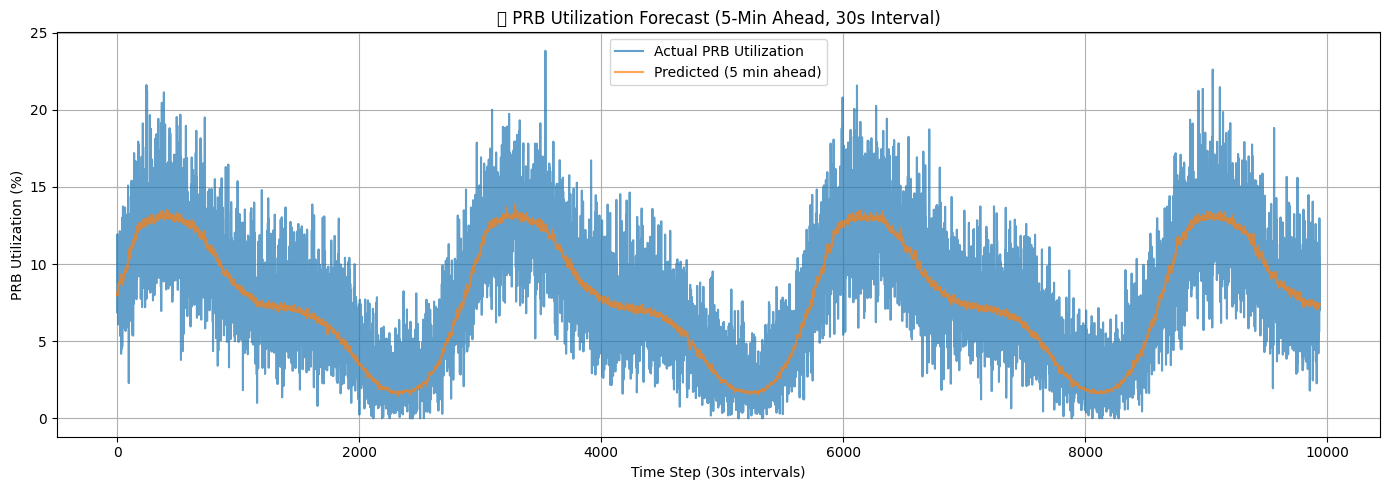

In [ ]:

mae = mean_absolute_error(true_vals, pred_vals)
rmse = mean_squared_error(true_vals, pred_vals)
r2 = r2_score(true_vals, pred_vals)

print(f"\n📊 Accuracy on Test Stream (5-min ahead):")
print(f"✅ MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
import matplotlib.pyplot as plt

# === Optional Plotting ===
plt.figure(figsize=(14, 5))
plt.plot(true_vals, label="Actual PRB Utilization", color='tab:blue', alpha=0.7)
plt.plot(pred_vals, label="Predicted (5 min ahead)", color='tab:orange', alpha=0.7)
plt.xlabel("Time Step (30s intervals)")
plt.ylabel("PRB Utilization (%)")
plt.title("📈 PRB Utilization Forecast (5-Min Ahead, 30s Interval)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("prb_forecast_plot.png")
plt.show()
